W tym zadaniu zajmiemy się ekstrakcją melowo-częstotliwościowych współczynników cepstralnych (MFCC - *mel frequency cepstral coefficients*).

MFCC to cechy bardzo często ekstrahowane z sygnałów akustycznych z zakresu słyszalnego, głównie sygnału mowy. Uzyskiwane są poprzez filtrację cepstrum (cepstrum - odwrotna transformata Fouriera z widma wyrażonego w skali logarytmicznej) bankiem filtrów trójkątnych. Filtry te są dobrane tak, by w (dużym) przybliżeniu modelować odpowiedź układu słuchowego człowieka na sygnał akustyczny. Rodzielczość częstotliwościowa słuchu jest wyższa dla niskich częstotliwości, a niższa dla wysokich, więc filtry melowe są węższe dla niskich częstotliwości i szersze dla wysokich.

Algorytm ekstrakcji MFCC jest w skrócie opisany np. w skrypcie przedmiotowym na str. 34, [tutaj (str. 14-15)](https://home.agh.edu.pl/~jgalka/dydaktyka/tm/Jakub_Galka_Technologia_Mowy_Wyklady_2021.pdf) lub [tutaj (ang.)](https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html).

1. Wyświetl spektrogram dowolnego sygnału z poprzedniego zadania (folder dane_testowe).

In [14]:
from scipy.io.wavfile import read as read_wav
from scipy.signal import ShortTimeFFT
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

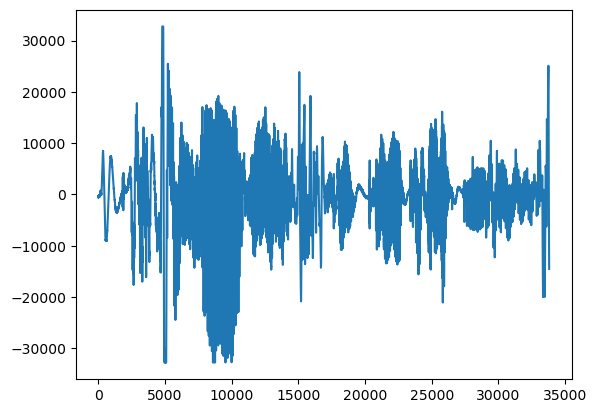

In [15]:
files_phrase = np.loadtxt('files_phrase.txt', dtype=str)
fs, data = read_wav(os.path.join('dane_testowe', files_phrase[1]))
plt.plot(data)

In [16]:
STFT = ShortTimeFFT.from_window('hann', fs=fs, nperseg=256, noverlap=128, mfft=1024)
S = STFT.spectrogram(data)
t = STFT.t(len(data))
f = STFT.f

Text(0, 0.5, 'Częstotliwość [Hz]')

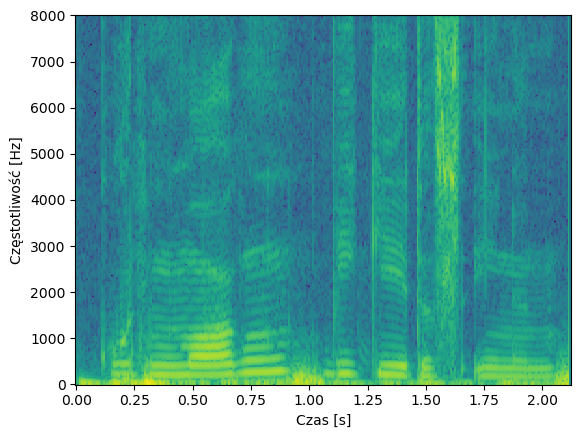

In [17]:
plt.pcolormesh(t, f, 10*np.log10(S))
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')

2. Wyznacz MFCC dla tego samego sygnału - możesz skorzystać np. z biblioteki librosa, która zawiera dużo wysokopoziomowych funkcji do analizy sygnałów:

In [18]:
import librosa
# x, fs = librosa.load('nazwa_pliku.wav')
mfcc_20_coeffs = librosa.feature.mfcc(y=data.astype(float), sr=fs, n_mfcc=20)
print(mfcc_20_coeffs.shape) #pierwszy wymiar - liczba współczynników MFCC, drugi - liczba ramek sygnału

(20, 67)


Liczba współczynników jest domyślnie ustawiona na 20 i można ją zmienić podając do funkcji argument `n_mfcc`. Najmniejszą często używaną liczbą współczynników jest 13. 

In [19]:
mfcc_13_coeffs = librosa.feature.mfcc(y=data.astype(float), sr=fs, n_mfcc=13)

3. Wyświetl obie zmienne z MFCC jako obraz (funkcja `plt.imshow`). Porównaj wygląd obu obrazów oraz ich wymiary.

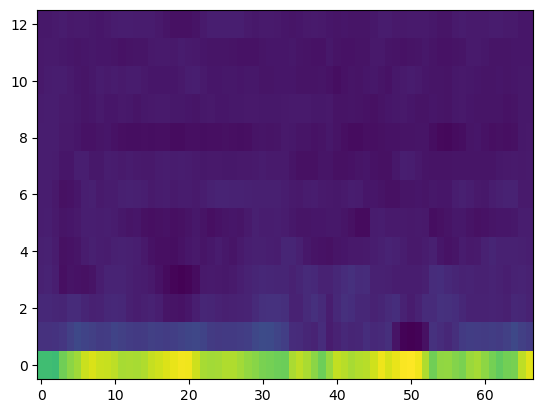

In [20]:
plt.imshow(mfcc_13_coeffs, aspect='auto', origin='lower')


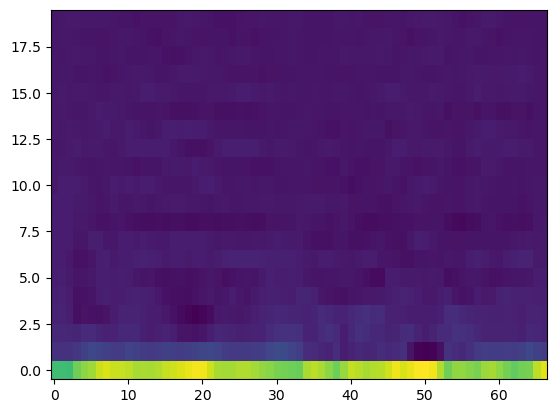

In [21]:
plt.imshow(mfcc_20_coeffs, aspect='auto', origin='lower')

4. Wytrenuj klasyfikator analogicznie do zadania 1, ale tym razem na MFCC, a nie na spektrogramach (użyj części kodu z poprzedniego zadania lub zapisanych w tym celu skryptów). Pamiętaj o zachowaniu takiego samego podziału sygnałów na zbiory uczący i testowy (w poprzednim zadaniu trzeba było zapisać listę plików w obu zbiorach do plików - możesz ich użyć lub zastosować taką samą wartość `random_state` w funkcji `train_test_split`).

In [22]:
mfccs = []
for file in files_phrase:
    fs, data = read_wav(os.path.join('dane_testowe', file))
    mfcc_20_coeffs = librosa.feature.mfcc(y=data.astype(float), sr=fs, n_mfcc=20)
    mfccs.append(mfcc_20_coeffs)

max_len = max(mfcc.shape[1] for mfcc in mfccs)
mfccs_padded = []
for mfcc in mfccs:
    pad_width = max_len - mfcc.shape[1]
    mfcc_padded = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    mfccs_padded.append(mfcc_padded)

mfccs_3d = np.stack(mfccs_padded, axis=0)
print(mfccs_3d.shape)

(20, 20, 89)


In [23]:
files_labeled = pd.read_csv('files_labeled.csv')
labels = files_labeled['label'].values

X_train, X_test, y_train, y_test = train_test_split(mfccs_3d, labels, 
                                                    stratify=labels, 
                                                    test_size=0.2,
                                                    random_state=101)
print(y_train, y_test)

[0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0] [0 1 0 1]


In [24]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape, X_test.shape)

(16, 1780) (4, 1780)


5. Wylicz metryki sukcesu i oceń, czy zmiana rodzaju użytych cech sygnału ma wpływ na wyniki.
Pamiętaj o napisaniu odpowiedzi na platformie upel.

In [25]:
model = KNeighborsClassifier(n_neighbors=5)
    
model.fit(X_train,y_train)

KNeighborsClassifier()

In [26]:
preds = model.predict(X_test)

print(confusion_matrix(y_test, preds))

print(classification_report(y_test, preds))

[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

